In [1]:
import boto3
import pandas as pd
import numpy as np
import io
import os
import json
import joblib
import seaborn as sns
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

In [2]:
# Configutations S3 access and data
load_dotenv()
aws_access_key_id = os.getenv('aws_access_key_id')
aws_secret_access_key = os.getenv('aws_secret_access_key')

In [3]:
# S3 connection
s3 = boto3.client(
    service_name = "s3",
    region_name = "eu-west-3",
    aws_access_key_id = aws_access_key_id,
    aws_secret_access_key = aws_secret_access_key,
)

In [4]:
# Specific bucket data
bucket_name = "hotel-resa-prediction"
prefix = "datasets/"
filename = "processed_hotel_bookings.csv"

In [5]:
# get datas 
result = s3.list_objects(Bucket=bucket_name)
for obj in result.get('Contents'):
    if (obj["Key"].startswith(prefix)) and (obj["Key"].endswith(filename)):
        data = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        contents = data['Body'].read().decode("utf-8")
        data = pd.read_csv(io.StringIO(contents), low_memory=False)

In [6]:
X = data.drop("is_canceled",  axis=1)
y = data["is_canceled"]
print("Features : ", X.shape)
print("Target : ", y.shape) # s'assurer de n'avoir qu'une colonne ici

Features :  (119210, 30)
Target :  (119210,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    shuffle=True, 
    stratify=y # IMPORTANT pour bien balancer les prédictions première itération --> courbe ROC mauvais 
)
print("Features train : ", X_train.shape)
print("Target train : ", y_train.shape)
print("Features test : ", X_test.shape)
print("Target test : ", y_test.shape)

Features train :  (83447, 30)
Target train :  (83447,)
Features test :  (35763, 30)
Target test :  (35763,)


In [8]:
# Pour voir la distribution dans y_train --> Valider le stratify
print("Distribution y_train:")
print(y_train.value_counts())
print("\nPourcentages y_train:")
print(y_train.value_counts(normalize=True) * 100)

# Pour voir la distribution dans y_test --> Valider  le stratify
print("\nDistribution y_test:")
print(y_test.value_counts())
print("\nPourcentages y_test:")
print(y_test.value_counts(normalize=True) * 100)

# Pour voir la distribution dans le dataset complet --> Valider  le stratify
print("\nDistribution dataset complet:")
print(y.value_counts())
print("\nPourcentages dataset complet:")
print(y.value_counts(normalize=True) * 100)

Distribution y_train:
is_canceled
0    52508
1    30939
Name: count, dtype: int64

Pourcentages y_train:
is_canceled
0    62.923772
1    37.076228
Name: proportion, dtype: float64

Distribution y_test:
is_canceled
0    22503
1    13260
Name: count, dtype: int64

Pourcentages y_test:
is_canceled
0    62.922574
1    37.077426
Name: proportion, dtype: float64

Distribution dataset complet:
is_canceled
0    75011
1    44199
Name: count, dtype: int64

Pourcentages dataset complet:
is_canceled
0    62.923412
1    37.076588
Name: proportion, dtype: float64


In [9]:
categorical_data = selector(dtype_include=object)
numerical_data = selector(dtype_exclude=object)

In [10]:
n_categorical = categorical_data(X)
n_numerical = numerical_data(X)

In [11]:
print(f"Categorial : {len(n_categorical)}")
print(f"Numerical : {len(n_numerical)}")

Categorial : 15
Numerical : 15


In [12]:
prefix_model = "models/"
filename_model = "hotel_bookings_churn_model.pkl"

In [13]:
result_model = s3.list_objects(Bucket=bucket_name)
for obj in result_model.get('Contents'):
    if (obj["Key"].startswith(prefix_model)) and (obj["Key"].endswith(filename_model)):
        model = s3.get_object(Bucket=bucket_name, Key=obj.get('Key'))
        model_content = model['Body'].read()
        model_pipeline = joblib.load(io.BytesIO(model_content))

In [14]:
model_pipeline
model_pipeline.set_params(randomforestclassifier__n_jobs=1)
model_pipeline.set_params(randomforestclassifier__verbose=2)

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [16]:
params = {
  # 1️⃣  taille de la forêt (cours : centaines → milliers)
  "randomforestclassifier__n_estimators":    [10, 50],

  # 2️⃣  bouton principal m pour décorréler
  "randomforestclassifier__max_features":    ["sqrt", 0.33, "log2", None],

  # 3️⃣  biais vs profondeur
  "randomforestclassifier__min_samples_leaf":[1, 2, 5]
}
# 3×4×3 = 36 combos → 36×3 = 108 fits au lieu de 600

In [17]:
search_cv = GridSearchCV(
    model_pipeline,
    param_grid=params,
    scoring="accuracy",
    cv=3,  # Réduire le CV de 5 à 3
    n_jobs=-1,  # Parallélisation seulement ici
    error_score='raise',
    verbose=2  # Ajouter de la verbosité pour voir le progrès
)


In [18]:
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, 
    train_size=0.1,  # 10% des données seulement
    stratify=y_train,
    random_state=42
)

In [20]:
print(f"Test sur échantillon réduit: {X_sample.shape}")
search_cv.fit(X_sample, y_sample)

Test sur échantillon réduit: (8344, 30)
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.5s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.5s finished
[Parallel(n_j

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.9s


building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.4s finished


,estimator,Pipeline(step... verbose=2))])
,param_grid,"{'randomforestclassifier__max_features': ['sqrt', 0.33, ...], 'randomforestclassifier__min_samples_leaf': [1, 2, ...], 'randomforestclassifier__n_estimators': [10, 50]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"


In [21]:
search_cv.fit(X_train, y_train) 

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__n_estimators=10; total time=   0.3s
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tr

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10; total time=   0.2s
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__n_estimators=10; total time=   0.2s
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclas

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   12.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   12.8s


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.6s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   12.7s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.4s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   16.5s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    8.2s
[Parallel(n_j

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__n_estimators=10; total time=   0.3s
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10; total time=   0.2s
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclas

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   47.5s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   47.6s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   48.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  50 out of  50 | ela

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10; total time=   0.2s
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tr

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__n_estimators=10; total time=   0.3s
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tr

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   54.6s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   54.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished
[Par

building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   55.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    


[CV] END randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=50; total time=   4.7s
building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10
[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10; total time=   0.2s
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 2

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   46.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   37.7s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   36.5s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   37.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   58.0s finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: 


[CV] END randomforestclassifier__max_features=sqrt, randomforestclassifier__min_samples_leaf=5, randomforestclassifier__n_estimators=50; total time=   0.5s
building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.2s finished


building tree 1 of 50
building tree 2 of 50
building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:   55.7s


building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.2min finished


,estimator,Pipeline(step... verbose=2))])
,param_grid,"{'randomforestclassifier__max_features': ['sqrt', 0.33, ...], 'randomforestclassifier__min_samples_leaf': [1, 2, ...], 'randomforestclassifier__n_estimators': [10, 50]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"


In [22]:
cv_results = search_cv.cv_results_ 

In [24]:
pd.DataFrame(cv_results).sort_values(by="rank_test_score", ascending=True).head(3) 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_features,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,80.149257,0.867088,0.524788,0.013580,0.33,1,50,"{'randomforestclassifier__max_features': 0.33,...",0.879494,0.878415,0.875750,0.877887,0.001573,1
9,68.878871,0.630870,0.542719,0.030065,0.33,2,50,"{'randomforestclassifier__max_features': 0.33,...",0.876150,0.876762,0.875067,0.875993,0.000701,2
19,193.511562,2.194813,0.430160,0.046069,None,1,50,"{'randomforestclassifier__max_features': None,...",0.876007,0.877085,0.874276,0.875789,0.001157,3


In [25]:
best_model = search_cv.best_estimator_
best_model

,steps,"[('columntransformer', ...), ('randomforestclassifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...), ('Categorical', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
result = best_model.predict(X_test) 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished


In [27]:
accuracy = accuracy_score(y_test, result)
precision = precision_score(y_test, result)
recall = recall_score(y_test, result)

In [28]:
print(f"The accuracy score : {accuracy*100:.3f}%")
print(f"The precision score: {precision*100:.3f}%")
print(f"The recall score: {recall*100:.3f}%")

The accuracy score : 88.413%
The precision score: 86.961%
The recall score: 80.875%


In [29]:
confusion_matrix = confusion_matrix(y_test, result) 

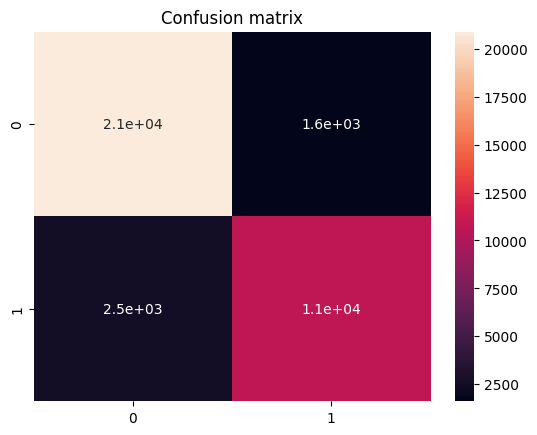

In [30]:
_ = sns.heatmap((confusion_matrix), annot=True).set(title="Confusion matrix") 

In [31]:
label_map = {1: "Not Placed", 0: "Placed"}
y_train = y_train.map(label_map)

/var/folders/6j/prwx2hms3hzdtbw453ddk_k40000gn/T/ipykernel_16737/3839045546.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_mapped = y_train.replace(label_map)


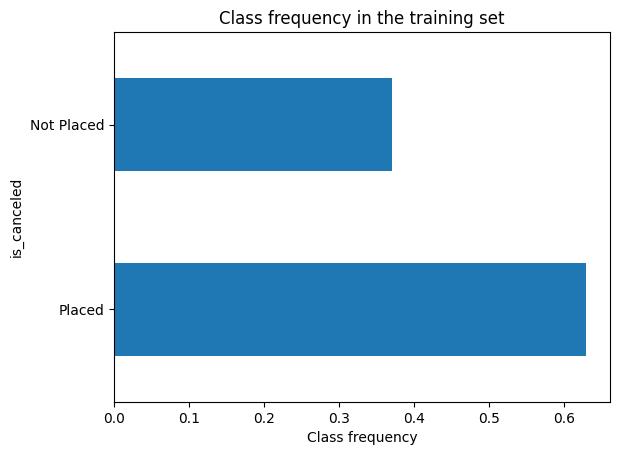

In [32]:
label_map = {"Placed": 0, "Not Placed": 1}
y_train_mapped = y_train.replace(label_map)
pd.Series(y_train).value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
plt.title("Class frequency in the training set")
plt.show()

-- END --